In [14]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!kaggle kernels output sndpkirwai/cyberbully-detection-text-classification -p .

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Output file downloaded to ./clean_preprocess_twit_data.csv
Output file downloaded to ./model.png
Output file downloaded to ./sentiment_classification_model.h5
Output file downloaded to ./tokenizer.pickle
Kernel log downloaded to ./cyberbully-detection-text-classification.log 


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate


df = pd.read_csv("clean_preprocess_twit_data.csv")
df =df.where(pd.notnull(df), 'none')
df.head()

,Text,Annotation,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,halalflaws biebervalue greenlinerzjm read cont...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 idiot claim people try stop becom...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,rt mooseoftorment call sexist go auto place id...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,sipsquirrelx wrong isi follow example mohammed...
4,#mkr No No No No No No,none,0.0,mkr


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['Annotation'], test_size=0.33, random_state=42)

In [4]:
categories = df["Annotation"].unique()
categories

array(['none', 'sexism', 'racism'], dtype=object)

In [5]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train == category)
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test == category, prediction)))

... Processing none
Test accuracy is 0.7969789606185937
... Processing sexism
Test accuracy is 0.8370796619313073
... Processing racism
Test accuracy is 0.9018162201042977


In [6]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train == category)
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test == category, prediction)))

... Processing none
Test accuracy is 0.8401366660672541
... Processing sexism
Test accuracy is 0.9036144578313253
... Processing racism
Test accuracy is 0.9426362165078224


In [7]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train == category)
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test == category, prediction)))

... Processing none
Test accuracy is 0.8268297068872505
... Processing sexism
Test accuracy is 0.8831145477432116
... Processing racism
Test accuracy is 0.9320266139183601


In [8]:
df.head()

,Text,Annotation,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,halalflaws biebervalue greenlinerzjm read cont...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 idiot claim people try stop becom...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,rt mooseoftorment call sexist go auto place id...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,sipsquirrelx wrong isi follow example mohammed...
4,#mkr No No No No No No,none,0.0,mkr


In [10]:
one_hot = pd.get_dummies(df['Annotation'])
df_rnn = df.drop(['Annotation', 'oh_label'],axis = 1)
df_rnn = df_rnn.join(one_hot)
df_rnn

,Text,cleaned_text,none,racism,sexism
0,@halalflaws @biebervalue @greenlinerzjm I read...,halalflaws biebervalue greenlinerzjm read cont...,1,0,0
1,@ShreyaBafna3 Now you idiots claim that people...,shreyabafna3 idiot claim people try stop becom...,1,0,0
2,"RT @Mooseoftorment Call me sexist, but when I ...",rt mooseoftorment call sexist go auto place id...,0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",sipsquirrelx wrong isi follow example mohammed...,0,1,0
4,#mkr No No No No No No,mkr,1,0,0
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",feel sorry girl safe kat andre go home mkr,1,0,0
16847,#MKR 'pretty good dishes we're happy with' - O...,mkr pretty good dish happy ok well im never ea...,1,0,0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,rt colonelkickheatonguestickingoutcheekyplayfu...,1,0,0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,versacezaynx nyazpolitics greenlinerzjm stupid...,1,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_rnn['cleaned_text'], df_rnn[['none',	'racism', 'sexism']], test_size=0.33, random_state=19)

In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt
!unzip glove6b100dtxt.zip

glove6b100dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  glove6b100dtxt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [34]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [35]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

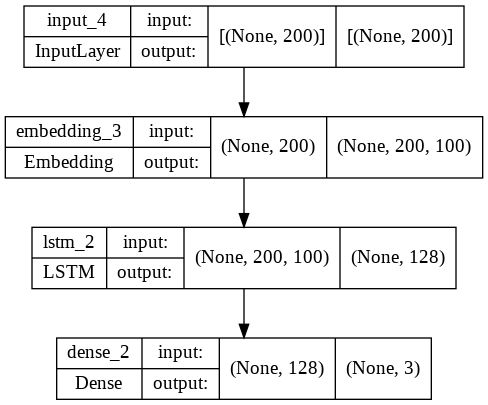

In [36]:
from keras.utils.vis_utils  import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [38]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
71/71 [==============================] - 1s 18ms/step - loss: 0.5020 - acc: 0.6766 - val_loss: 0.4893 - val_acc: 0.6900
Epoch 2/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5014 - acc: 0.6766 - val_loss: 0.4895 - val_acc: 0.6900
Epoch 3/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5015 - acc: 0.6766 - val_loss: 0.4886 - val_acc: 0.6900
Epoch 4/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5012 - acc: 0.6766 - val_loss: 0.4901 - val_acc: 0.6900
Epoch 5/10
71/71 [==============================] - 1s 17ms/step - loss: 0.5016 - acc: 0.6766 - val_loss: 0.4886 - val_acc: 0.6900
Epoch 6/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5015 - acc: 0.6766 - val_loss: 0.4888 - val_acc: 0.6900
Epoch 7/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5014 - acc: 0.6766 - val_loss: 0.4888 - val_acc: 0.6900
Epoch 8/10
71/71 [==============================] - 1s 16ms/step - loss: 0.5015 - a

In [39]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

174/174 [==============================] - 1s 6ms/step - loss: 0.4889 - acc: 0.6896
Test Score: 0.48890629410743713
Test Accuracy: 0.6896241903305054


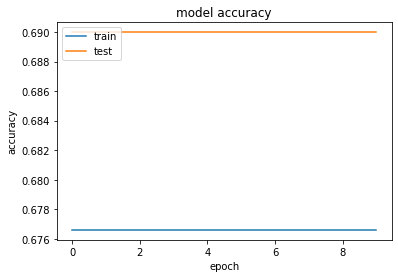

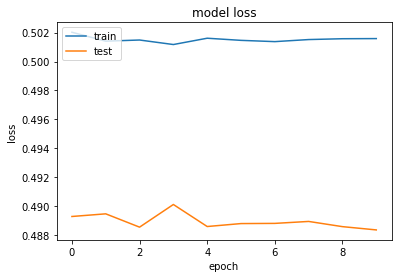

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_rnn['cleaned_text'], df_rnn[['none',	'racism', 'sexism']], test_size=0.33, random_state=42)

In [42]:
# First output
y1_train = y_train[["none"]].values
y1_test =  y_test[["none"]].values

# Second output
y2_train = y_train[["sexism"]].values
y2_test =  y_test[["sexism"]].values

# Third output
y3_train = y_train[["racism"]].values
y3_test =  y_test[["racism"]].values

In [43]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [44]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [45]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

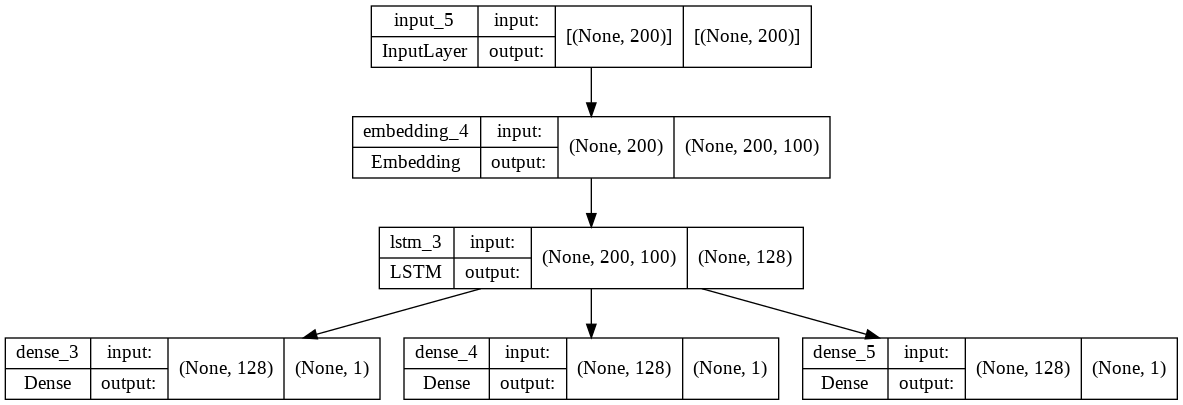

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [47]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train], batch_size=8192, epochs=20, verbose=1, validation_split=0.2)


Epoch 1/20
2/2 [==============================] - 4s 649ms/step - loss: 2.0787 - dense_3_loss: 0.6931 - dense_4_loss: 0.6929 - dense_5_loss: 0.6927 - dense_3_acc: 0.3576 - dense_4_acc: 0.7944 - dense_5_acc: 0.8836 - val_loss: 2.0618 - val_dense_3_loss: 0.6912 - val_dense_4_loss: 0.6872 - val_dense_5_loss: 0.6834 - val_dense_3_acc: 0.6997 - val_dense_4_acc: 0.8153 - val_dense_5_acc: 0.8844
Epoch 2/20
2/2 [==============================] - 1s 123ms/step - loss: 2.0613 - dense_3_loss: 0.6913 - dense_4_loss: 0.6872 - dense_5_loss: 0.6828 - dense_3_acc: 0.6780 - dense_4_acc: 0.7944 - dense_5_acc: 0.8836 - val_loss: 2.0336 - val_dense_3_loss: 0.6881 - val_dense_4_loss: 0.6776 - val_dense_5_loss: 0.6680 - val_dense_3_acc: 0.6997 - val_dense_4_acc: 0.8153 - val_dense_5_acc: 0.8844
Epoch 3/20
2/2 [==============================] - 1s 122ms/step - loss: 2.0333 - dense_3_loss: 0.6885 - dense_4_loss: 0.6780 - dense_5_loss: 0.6669 - dense_3_acc: 0.6780 - dense_4_acc: 0.7944 - dense_5_acc: 0.8836 - 

In [48]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

174/174 [==============================] - 1s 8ms/step - loss: 1.4732 - dense_3_loss: 0.6204 - dense_4_loss: 0.5032 - dense_5_loss: 0.3497 - dense_3_acc: 0.6839 - dense_4_acc: 0.8011 - dense_5_acc: 0.8822
Test Score: 1.4732434749603271
Test Accuracy: 0.6204127669334412


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

KeyError: ignored